In [58]:
import copy

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import json

In [38]:
filename = '/Users/tsievert/GA Caltech/QAE_4_HEP/ga_runs/run-2023-10-24_13-09-45/final_evolution_results.json'

dict = None
with open(filename, 'r') as f: # open in readonly mode
    dict = json.load(f)

In [39]:
print(dict.keys())

dict_keys(['full_population_vectors', 'full_population_drawings', 'final_max_vector_moments', 'full_population_fitness', 'full_tsne_data', 'per_gen_diversity', 'full_pop_diversity', 'current_generation', 'current_drawn_generation', 'current_generation_fitness', 'fitness_stats', 'best_ansatz', 'best_drawn_ansatz', 'best_fitness', 'best_fitness_gen', 'best_fitness_ix', 'full_population_metrics', 'eval_metrics', 'eval_metrics_stats', 'best_eval_metrics'])


In [40]:
full_pop_drawn_circuits = dict['full_population_drawings']
full_pop_fitness = dict['full_population_fitness']
full_pop_auroc = [i['auroc'] for i in dict['full_population_metrics']]
full_tsne_data = dict['full_tsne_data']
per_gen_diversity = dict['per_gen_diversity']

In [41]:
sorted_auroc = [i.item() for i in np.argsort(full_pop_auroc)]

In [42]:
print(f'median is: {np.median(full_pop_auroc)}')
print(f'iqr is: {scp.stats.iqr(full_pop_auroc)}')

median is: 0.8494153846153847
iqr is: 0.16738461538461524


In [43]:
print(f"auroc = {dict['best_eval_metrics']['auroc']}")
print(f"fitness = {dict['best_fitness']}")
print(dict['best_drawn_ansatz'])
print(f"gen = {dict['best_fitness_gen']}, index = {dict['best_fitness_ix']}")

auroc = 0.709374358974359
fitness = 0.9890395
0: ─────╭●─────╭X─────╭●──RZ─┤     
1: ──RX─│───Rϕ─│───RY─│──────┤     
2: ─────╰X─────╰●──Rϕ─╰X─────┤  
gen = 14, index = 1


In [44]:
worst_indeces = sorted_auroc[:]

for circuit_ix in worst_indeces:
    print(f'auroc = {full_pop_auroc[circuit_ix]}')
    print(f"fitness = {full_pop_fitness[circuit_ix]}")
    print(full_pop_drawn_circuits[circuit_ix])
    print(f'\n{"-"*40}\n')

auroc = 0
fitness = 0
0: ────────────────────────────────┤ 
1: ────────────────────────────────┤ 
2: ────────────────────────────────┤  

----------------------------------------

auroc = 0.06691282051282052
fitness = 0.9571485
0: ─────╭X──RX─────╭●─────┤     
1: ──RX─│───RZ──Rϕ─│──────┤     
2: ─────╰●─────────╰X──RX─┤  

----------------------------------------

auroc = 0.10036923076923077
fitness = 0.354244
0: ──RX─╭●─────╭X──RZ─┤     
1: ──RY─│───Rϕ─│──────┤     
2: ─────╰X─────╰●──RX─┤  

----------------------------------------

auroc = 0.10687179487179488
fitness = 0.6676934999999999
0: ─╭X──────╭X──RX─────┤     
1: ─╰●───RX─│───Rϕ─────┤     
2: ──RY─────╰●──RX──RZ─┤  

----------------------------------------

auroc = 0.10982564102564102
fitness = 0.30671099999999996
0: ─╭X─╭●─────╭X─────────┤     
1: ─╰●─│───RX─│──────────┤     
2: ────╰X──RX─╰●──Rϕ──RZ─┤  

----------------------------------------

auroc = 0.12188717948717949
fitness = 0.914887
0: ──RX─────╭●──RX─────┤     
1

(0.9, 1.1)

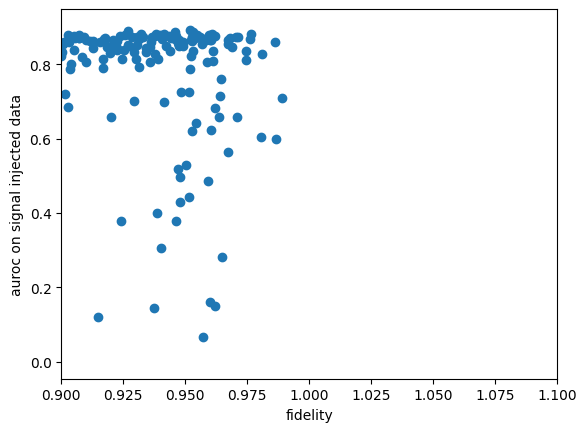

In [45]:
plt.scatter(full_pop_fitness, full_pop_auroc)
plt.xlabel('fidelity')
plt.ylabel('auroc on signal injected data')
plt.xlim([0.9, 1.1])

In [46]:
import ga_vqc as gav

gates_dict = {"I": (1, 0), "RX": (1, 1), "RY": (1, 1), "RZ": (1, 1), "PhaseShift": (1, 1), "CNOT": (2, 0)}
gates_probs = [0.15, 0.15, 0.15, 0.15, 0.15, 0.25]
genepool = gav.Genepool(gates_dict, gates_probs)

full_pop_circuits = []
for diagram in full_pop_drawn_circuits:
    full_pop_circuits.append(gav.Individual(3, 1, 1, genepool, rng_seed=None, diagram=diagram))

max_vector_moments = 0
for circuit in full_pop_circuits:
    if circuit.n_moments > max_vector_moments:
        max_vector_moments = circuit.n_moments

for circuit in full_pop_circuits:
    circuit.generate_vector(max_vector_moments)

In [92]:
## Euclidean Distances ##

euc_distances = []

for i in range(len(full_pop_circuits)):
    euc_distances.append(gav.euclidean_distances(full_pop_circuits[i], full_pop_circuits[0], full_pop_circuits[1:]))
euc_distances = np.array(euc_distances)
euc_distances = np.hstack(([[0]]+[[1] for _ in range(len(full_pop_circuits)-1)], euc_distances))

cutoff_threshold = 0.92
groupings = []
set_of_picked = set()

for i in range(1, len(full_pop_circuits)):
    current_group = [i]
    set_of_picked.add(i)

    for j in range(1, len(full_pop_circuits)):
        if j <= i or j in set_of_picked:
            continue
        
        add_flag = True
        for k in current_group:
            if euc_distances[k, j] >= cutoff_threshold:
                add_flag = False
        if add_flag:
            current_group.append(j)
            set_of_picked.add(j)

    groupings.append(copy.deepcopy(current_group))

In [97]:
for group in groupings:    
    for j in group:
        print('-'*30)
        print(f'fitness = {full_pop_fitness[j]:.03f}, auroc = {full_pop_auroc[j]:.03f}')
        print(full_pop_drawn_circuits[j])
    print('='*50)

------------------------------
fitness = 0.810, auroc = 0.689
0: ──Rϕ──RY─────────┤     
1: ─────╭●───RY─────┤     
2: ──RY─╰X───RX──Rϕ─┤  
------------------------------
fitness = 0.802, auroc = 0.868
0: ──Rϕ─╭X──────────────┤     
1: ─────╰●───RZ──Rϕ──RZ─┤     
2: ──RY──RZ──RX──Rϕ─────┤  
------------------------------
fitness = 0.802, auroc = 0.877
0: ─────╭●──RZ─────┤     
1: ──RZ─│───Rϕ─────┤     
2: ─────╰X──Rϕ──RZ─┤  
------------------------------
fitness = 0.907, auroc = 0.877
0: ─────╭●──Rϕ──RX─┤     
1: ─────│───Rϕ─────┤     
2: ──Rϕ─╰X──RY──RZ─┤  
------------------------------
fitness = 0.909, auroc = 0.873
0: ──RY──RX─┤     
1: ──RX─────┤     
2: ──Rϕ──RX─┤  
------------------------------
fitness = 0.031, auroc = 0.575
0: ──Rϕ──RX─┤     
1: ──RX──RZ─┤     
2: ──Rϕ──RX─┤  
------------------------------
fitness = 0.738, auroc = 0.874
0: ──RZ─╭X───RY─────╭●─┤     
1: ─╭●──╰●───Rϕ──RY─│──┤     
2: ─╰X───RY──Rϕ─────╰X─┤  
------------------------------
fitness = 0.939, auroc

In [ ]:
for i in groupings[0]:
    print(full_pop_drawn_circuits[i])